In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
if "google.colab" in sys.modules:
    from google.colab import auth
    auth.authenticate_user()

In [ ]:
!pip install -q mlflow
!pip install -q python-dotenv

In [ ]:
import os
project_folder = '/content/drive/MyDrive/nba-project'
os.chdir(project_folder)
pickles_folder = os.path.join(os.getcwd(), 'datasets')
os.getcwd()

'/content/drive/MyDrive/nba-project'

In [ ]:
import custom_modules.modelling_lib_rodrixx as mod
import custom_modules.preprocessing_lib_rodrixx as prep

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import os

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

from dotenv import load_dotenv

from mlflow.server import get_app_client
import mlflow

In [ ]:
env_path = os.path.join(os.getcwd(), 'env_files', '.env')
load_dotenv(env_path)
dataframes_path = os.path.join(os.getcwd(), 'datasets')
csv_path = os.path.join(os.getcwd(), 'column_csv')

In [ ]:
df = pd.read_pickle(os.path.join(dataframes_path, 'stats_1982_to_2023.pkl'))

In [ ]:
df.head()

,Rk,Player,Pos,Age,Tm,G,GS,MP_pg,FG_pg,FGA_pg,...,DBPM_rank,BPM_rank,VORP_rank,%W,GT,%W_rank,%G,Votes,Share,MaxVotes
0,1,Kareem Abdul-Jabbar,C,34,LAL,76,76,35.2,9.9,17.1,...,20,5,8,0.695,82,3,0.927,31,0.045,690
1,2,Alvan Adams,C,27,PHO,79,75,30.3,6.4,13.0,...,10,13,15,0.561,82,10,0.963,0,0.000,690
2,3,Mark Aguirre,SF,22,DAL,51,20,28.8,7.5,16.1,...,48,34,36,0.341,82,36,0.622,0,0.000,690
3,4,Danny Ainge,SG,22,BOS,53,1,10.6,1.5,4.2,...,22,68,47,0.768,82,1,0.646,0,0.000,690
4,5,Tiny Archibald,PG,33,BOS,68,51,31.9,4.5,9.6,...,45,40,35,0.768,82,1,0.829,0,0.000,690


In [ ]:
cols_tot = [col for col in df.columns if '_tot' in col]
cols_to_drop = ['Rk', 'G', 'GS', 'GT', 'Votes', 'MaxVotes', 'Tm']
cols_to_drop += cols_tot
cols_to_filter = ['PER', 'WS/48', 'BPM', 'USG%']
col_to_ohe = 'Pos'

In [ ]:
pipe_clean = Pipeline(steps = [
    ('DropPlayersMultiTeams', prep.DropPlayersMultiTeams()),
    ('OutlierFilter', prep.OutlierFilter(q = .0005, col_to_filter = cols_to_filter)),
    ('SetIndex', prep.SetIndex()),
    ('OHE', prep.OHE(col_to_ohe)),
    ('DropColumns', prep.DropColumns(cols_to_drop)),
    ('DropPlayers', prep.DropPlayers()),
])

In [ ]:
df = pipe_clean.fit_transform(df)

In [ ]:
df.head()

,,Age,MP_pg,FG_pg,FGA_pg,FG%,3P_pg,3PA_pg,3P%,2P_pg,2PA_pg,...,VORP_rank,%W,%W_rank,%G,Share,Pos_C,Pos_PF,Pos_PG,Pos_SF,Pos_SG
Rk,Season,,,,,,,,,,,,,,,,,,,,,
1,1982,34,35.2,9.9,17.1,0.579,0.0,0.0,0.000,9.9,17.1,...,8,0.695,3,0.927,0.045,1,0,0,0,0
2,1982,27,30.3,6.4,13.0,0.494,0.0,0.0,0.000,6.4,13.0,...,15,0.561,10,0.963,0.000,1,0,0,0,0
3,1982,22,28.8,7.5,16.1,0.465,0.5,1.4,0.352,7.0,14.7,...,36,0.341,36,0.622,0.000,0,0,0,1,0
4,1982,22,10.6,1.5,4.2,0.357,0.1,0.3,0.294,1.4,3.8,...,47,0.768,1,0.646,0.000,0,0,0,0,1
5,1982,33,31.9,4.5,9.6,0.472,0.1,0.2,0.375,4.4,9.4,...,35,0.768,1,0.829,0.000,0,0,1,0,0


In [ ]:
len(df[df.index.get_level_values(1) > 2016]) / len(df)

0.20598116428925484

In [ ]:
val_df = df[df.index.get_level_values(1) > 2016]
dev_df = df[df.index.get_level_values(1) <= 2016]

In [ ]:
dev_df, sampling_ratio = mod.oversample(dev_df, os_param = 'ros', sampling_strategy = .4)

In [ ]:
X_train = dev_df.drop('Share', axis=1)
y_train = dev_df[['Share']]

X_val = val_df.drop('Share', axis=1)
y_val = val_df[['Share']]

In [ ]:
scaler = MinMaxScaler()
scaler.fit(pd.concat([X_train, X_val], ignore_index = True))

MinMaxScaler()

In [ ]:
datasets = {'train': X_train, 'val': X_val}
real_targets = {'train': y_train, 'val': y_val}

In [ ]:
# pipe_scale = Pipeline(steps = [
#     ('Scaler', scaler),
#     ('ArrayToDf', prep.ArrayToDataFrame(columns = X_train.columns))
# ])

In [ ]:
# for key, dataset in datasets.items():
#     index_param = dataset.index
#     pipe_scale.set_params(**{'ArrayToDf__index': index_param})
#     datasets[key] = pipe_scale.transform(dataset)

In [ ]:
mlflow.set_experiment('Random Forest')

<Experiment: artifact_location='gs://nba-mvp-prediction-mlflow-artifacts/3', creation_time=1699641677571, experiment_id='3', last_update_time=1699641677571, lifecycle_stage='active', name='Random Forest', tags={}>

In [ ]:
param_grid = {
    'max_depth': [8],
    'min_samples_split': [10],
    'max_features': [.5],
    'n_estimators': [230]
    }

In [ ]:
with mlflow.start_run():
    estimator = RandomForestRegressor(random_state = 23)

    model = GridSearchCV(estimator, param_grid, scoring = ('neg_root_mean_squared_error', 'r2'), refit = 'neg_root_mean_squared_error', cv = 10, verbose = 2)

    model.fit(X_train, y_train)

    results = model.cv_results_

    cv_scores = mod.get_cv_scores(results)

    best_model, best_params, best_cv_score = mod.retrieve_best(model)

    predicted_targets = mod.predict_model(best_model, datasets)

    mod.log_sampling_ratio_mlflow(sampling_ratio)

    mod.log_params_mlflow_rf(best_params)

    mod.log_metrics_mlflow(real_targets, predicted_targets, cv_scores)

    mod.log_advanced_metrics_mlflow(real_targets['val'], predicted_targets['val'])

    mod.log_model_mlflow(best_model)

    mod.log_features_mlflow(X_train, csv_path)

    mod.log_important_features_mlflow(mod.display_feature_importances(best_model))

    mod.log_val_results_mlflow(*mod.display_val_results_graphs(real_targets['val'], predicted_targets['val'], pipe_clean['DropPlayers'].players_list))

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END max_depth=8, max_features=0.5, min_samples_split=10, n_estimators=230; total time= 1.1min
[CV] END max_depth=8, max_features=0.5, min_samples_split=10, n_estimators=230; total time=  50.0s
[CV] END max_depth=8, max_features=0.5, min_samples_split=10, n_estimators=230; total time=  50.9s
[CV] END max_depth=8, max_features=0.5, min_samples_split=10, n_estimators=230; total time=  50.8s
[CV] END max_depth=8, max_features=0.5, min_samples_split=10, n_estimators=230; total time=  49.5s
[CV] END max_depth=8, max_features=0.5, min_samples_split=10, n_estimators=230; total time=  55.9s
[CV] END max_depth=8, max_features=0.5, min_samples_split=10, n_estimators=230; total time=  52.2s
[CV] END max_depth=8, max_features=0.5, min_samples_split=10, n_estimators=230; total time=  50.1s
[CV] END max_depth=8, max_features=0.5, min_samples_split=10, n_estimators=230; total time=  53.3s
[CV] END max_depth=8, max_features=0.5, min_samp

In [ ]:
mod.display_metrics(real_targets, predicted_targets, cv_scores)

,Train,CV,Validation
RMSE,0.015107,0.015780,0.031600
R2,0.990639,0.977323,0.679969


In [ ]:
contenders_df, no_contenders_df = mod.get_val_results(real_targets['val'], predicted_targets['val'], pipe_clean['DropPlayers'].players_list)

In [ ]:
mod.display_val_results(contenders_df, no_contenders_df)

Contenders Results:


,,Player,Share,PredShare
Rk,Season,,,
458,2017,Russell Westbrook,0.879,0.356650
173,2017,James Harden,0.746,0.530733
261,2017,Kawhi Leonard,0.495,0.547134
221,2017,LeBron James,0.330,0.263415
425,2017,Isaiah Thomas,0.080,0.177061
98,2017,Stephen Curry,0.051,0.241415
16,2017,Giannis Antetokounmpo,0.007,0.109053
453,2017,John Wall,0.007,0.076911
100,2017,Anthony Davis,0.002,0.116044


,,Player,Share,PredShare
Rk,Season,,,
195,2018,James Harden,0.955,0.732129
249,2018,LeBron James,0.731,0.320213
122,2018,Anthony Davis,0.441,0.196938
298,2018,Damian Lillard,0.205,0.146670
508,2018,Russell Westbrook,0.075,0.192962
16,2018,Giannis Antetokounmpo,0.074,0.125952
143,2018,Kevin Durant,0.065,0.216292
130,2018,DeMar DeRozan,0.032,0.021155
7,2018,LaMarcus Aldridge,0.006,0.049163


,,Player,Share,PredShare
Rk,Season,,,
18,2019,Giannis Antetokounmpo,0.932,0.602204
207,2019,James Harden,0.768,0.515878
184,2019,Paul George,0.352,0.117192
270,2019,Nikola Jokić,0.210,0.130056
124,2019,Stephen Curry,0.173,0.182736
305,2019,Damian Lillard,0.068,0.148936
155,2019,Joel Embiid,0.049,0.093671
150,2019,Kevin Durant,0.025,0.188911
301,2019,Kawhi Leonard,0.013,0.208644


,,Player,Share,PredShare
Rk,Season,,,
13,2020,Giannis Antetokounmpo,0.952,0.610185
251,2020,LeBron James,0.746,0.378298
199,2020,James Harden,0.363,0.432125
134,2020,Luka Dončić,0.198,0.160152
294,2020,Kawhi Leonard,0.166,0.166402
123,2020,Anthony Davis,0.081,0.328253
396,2020,Chris Paul,0.026,0.013470
297,2020,Damian Lillard,0.023,0.186933
262,2020,Nikola Jokić,0.018,0.040453


,,Player,Share,PredShare
Rk,Season,,,
263,2021,Nikola Jokić,0.961,0.479596
146,2021,Joel Embiid,0.580,0.148978
116,2021,Stephen Curry,0.449,0.205416
12,2021,Giannis Antetokounmpo,0.345,0.303868
396,2021,Chris Paul,0.138,0.037068
130,2021,Luka Dončić,0.042,0.172454
297,2021,Damian Lillard,0.038,0.181047
421,2021,Julius Randle,0.020,0.024593
439,2021,Derrick Rose,0.010,0.000234


,,Player,Share,PredShare
Rk,Season,,,
290,2022,Nikola Jokić,0.875,0.413891
162,2022,Joel Embiid,0.706,0.287459
12,2022,Giannis Antetokounmpo,0.595,0.286492
59,2022,Devin Booker,0.216,0.067146
141,2022,Luka Dončić,0.146,0.209267
526,2022,Jayson Tatum,0.043,0.074451
390,2022,Ja Morant,0.010,0.189209
126,2022,Stephen Curry,0.004,0.042929
438,2022,Chris Paul,0.002,0.055570


,,Player,Share,PredShare
Rk,Season,,,
143,2023,Joel Embiid,0.915,0.367946
249,2023,Nikola Jokić,0.674,0.426114
11,2023,Giannis Antetokounmpo,0.606,0.347884
465,2023,Jayson Tatum,0.280,0.241673
164,2023,Shai Gilgeous-Alexander,0.046,0.243558
338,2023,Donovan Mitchell,0.030,0.089453
428,2023,Domantas Sabonis,0.027,0.131304
125,2023,Luka Dončić,0.010,0.198232
108,2023,Stephen Curry,0.005,0.084853


No contenders results:


,,Player,Share,PredShare
Rk,Season,,,
1,2017,Álex Abrines,0.0,0.000225
2,2017,Quincy Acy,0.0,0.000225
3,2017,Steven Adams,0.0,0.000264
4,2017,Arron Afflalo,0.0,0.000225
5,2017,Alexis Ajinça,0.0,0.000225
...,...,...,...,...
535,2023,Thaddeus Young,0.0,0.000225
536,2023,Trae Young,0.0,0.056109
537,2023,Omer Yurtseven,0.0,0.000225


In [ ]:
no_contenders_df[no_contenders_df['PredShare'] > 0.1]

,,Player,Share,PredShare
Rk,Season,,,
66,2017,Jimmy Butler,0.0,0.154606
156,2017,Rudy Gobert,0.0,0.164272
434,2017,Karl-Anthony Towns,0.0,0.113530
126,2019,Anthony Davis,0.0,0.112572
35,2020,Bradley Beal,0.0,0.106628
177,2020,Rudy Gobert,0.0,0.100939
38,2021,Bradley Beal,0.0,0.120951
244,2021,Kyrie Irving,0.0,0.108274
528,2021,Zion Williamson,0.0,0.111941


<Axes: title={'center': 'Most important features'}, xlabel='Feature', ylabel='Importance coefficient'>

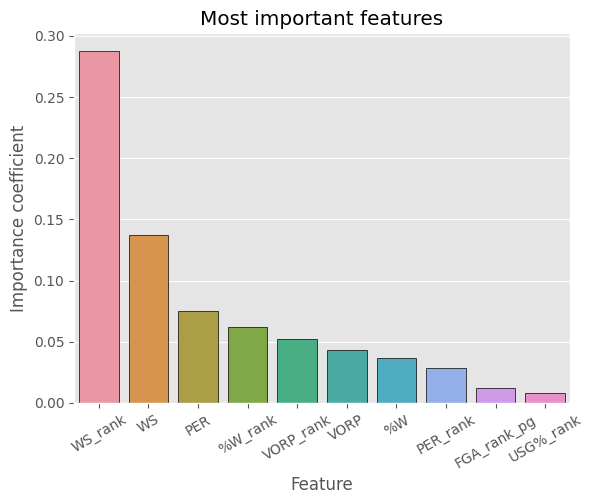

In [ ]:
mod.display_feature_importances(best_model)

In [ ]:
cont_df, no_cont_df = mod.get_val_results(real_targets['val'], predicted_targets['val'], pipe_clean['DropPlayers'].players_list)

(<Figure size 4000x4000 with 8 Axes>, <Figure size 4000x4000 with 8 Axes>)

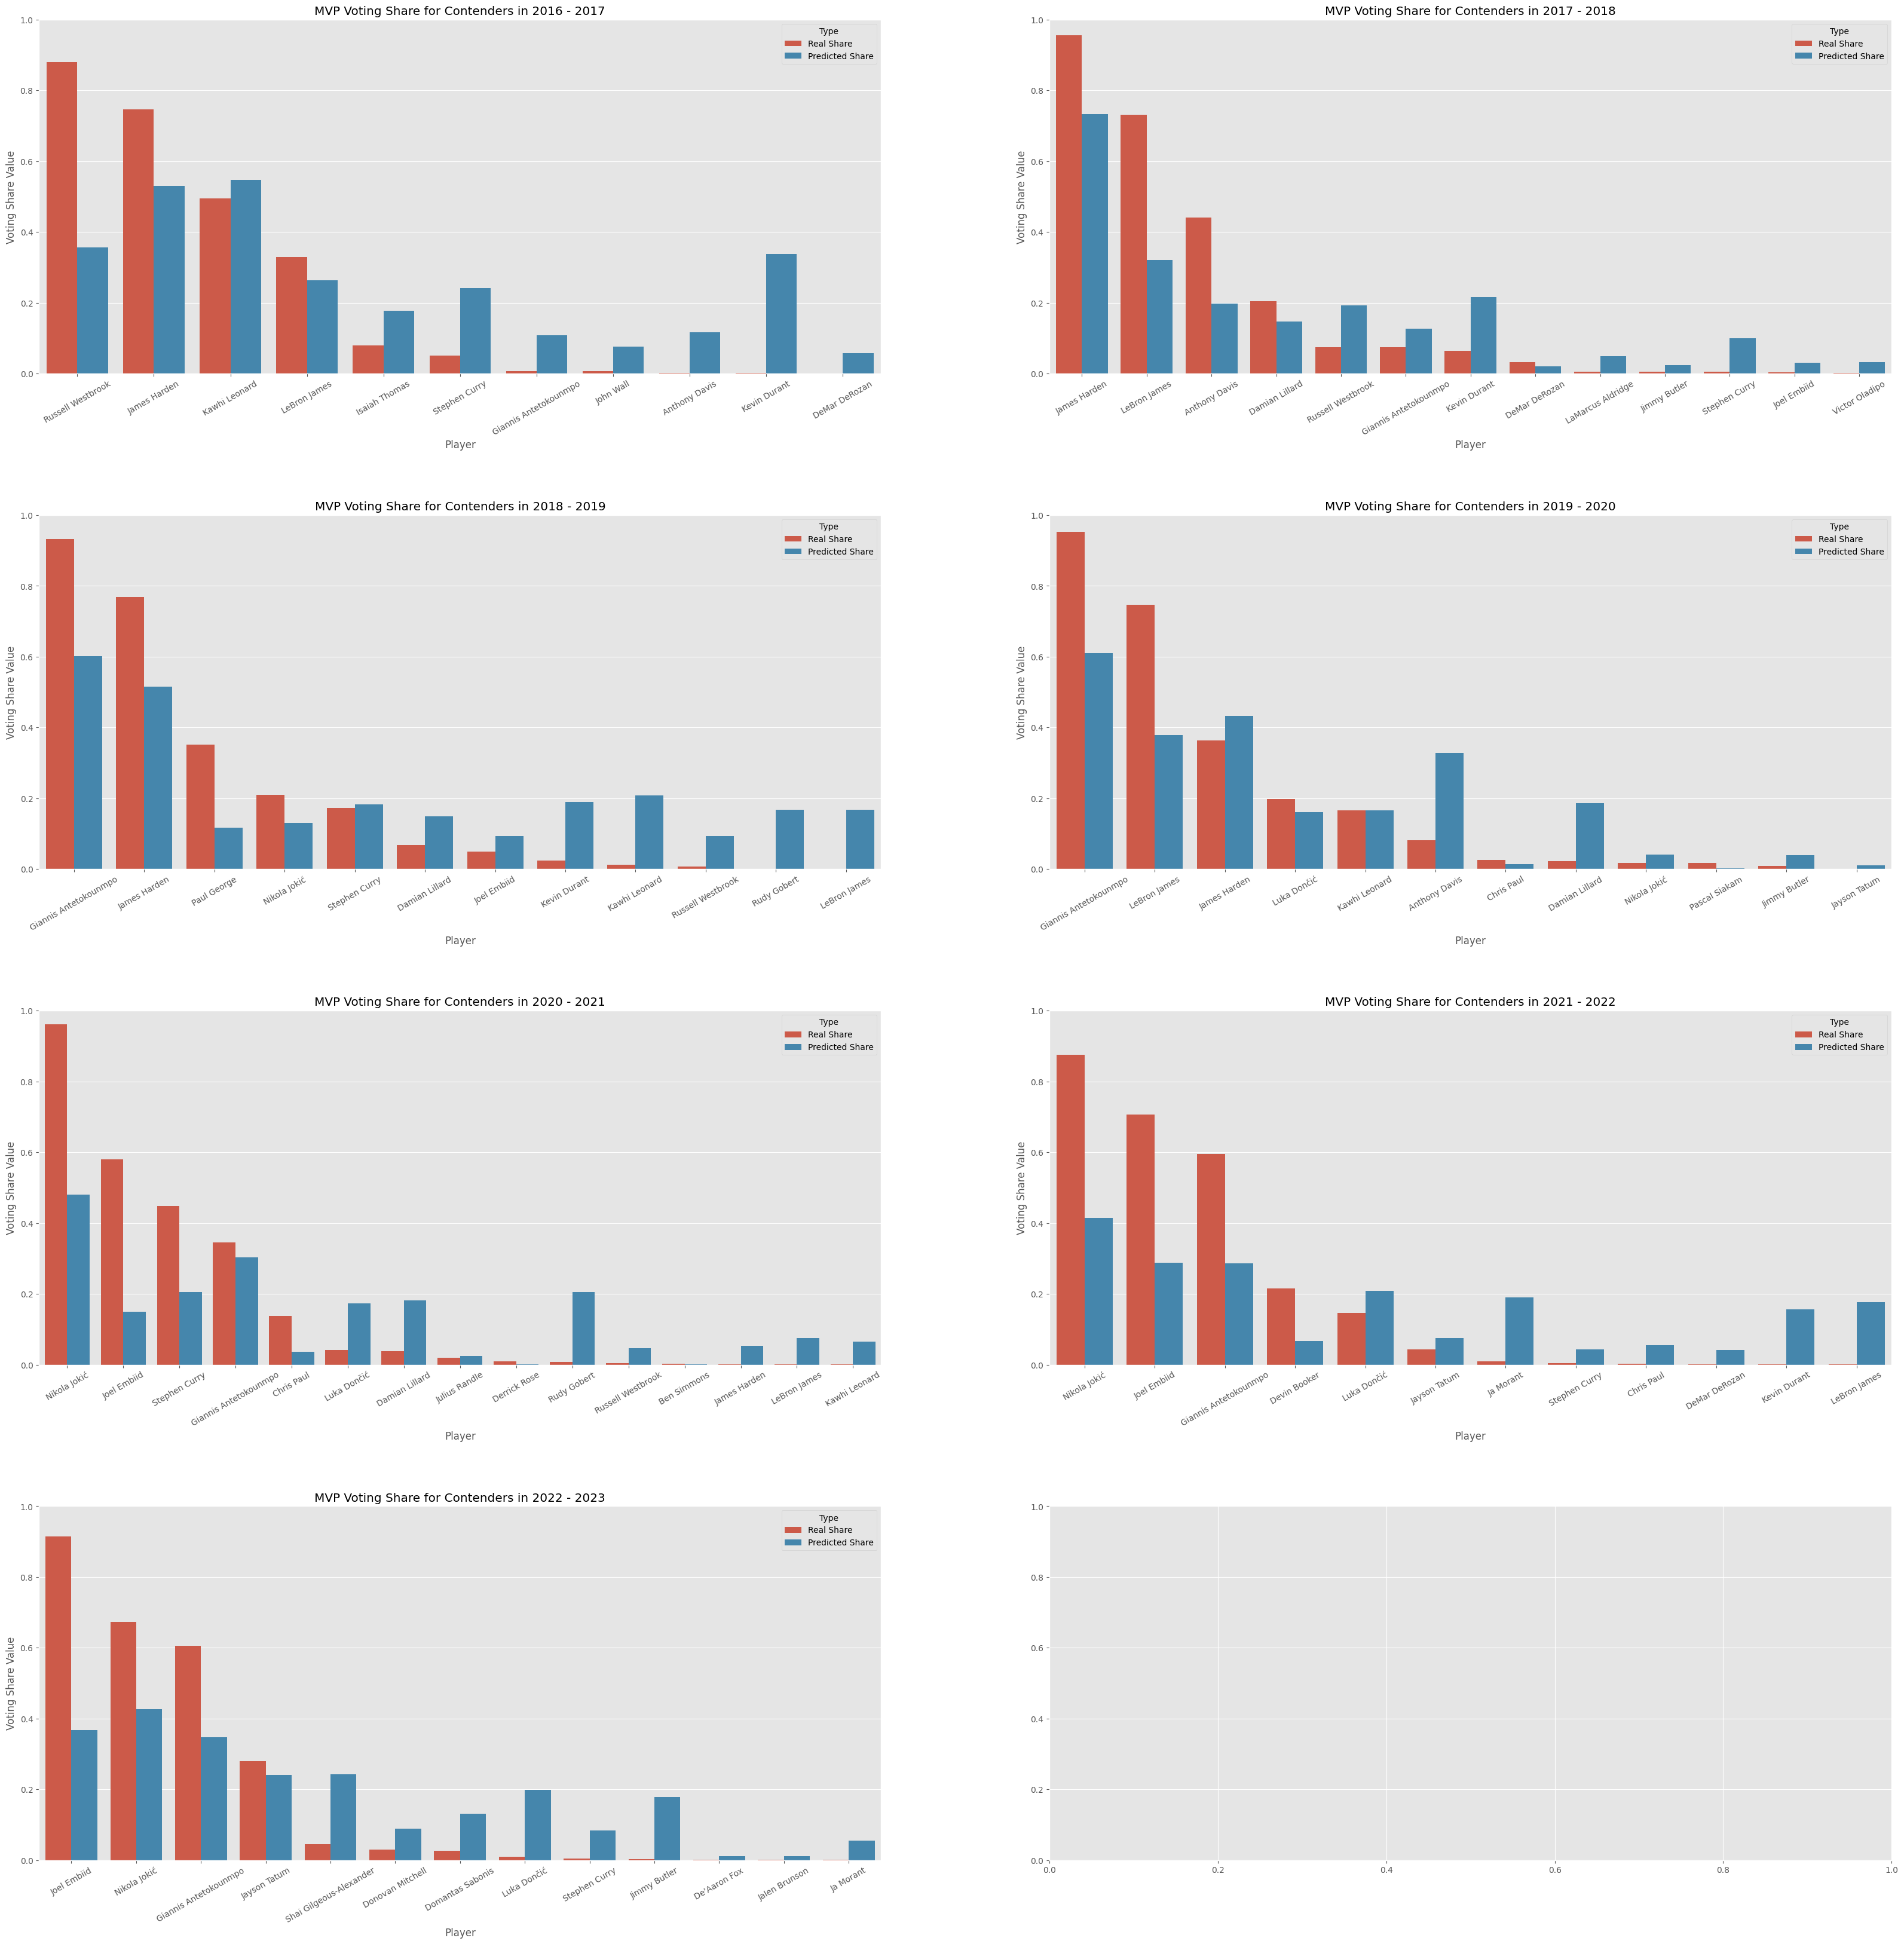

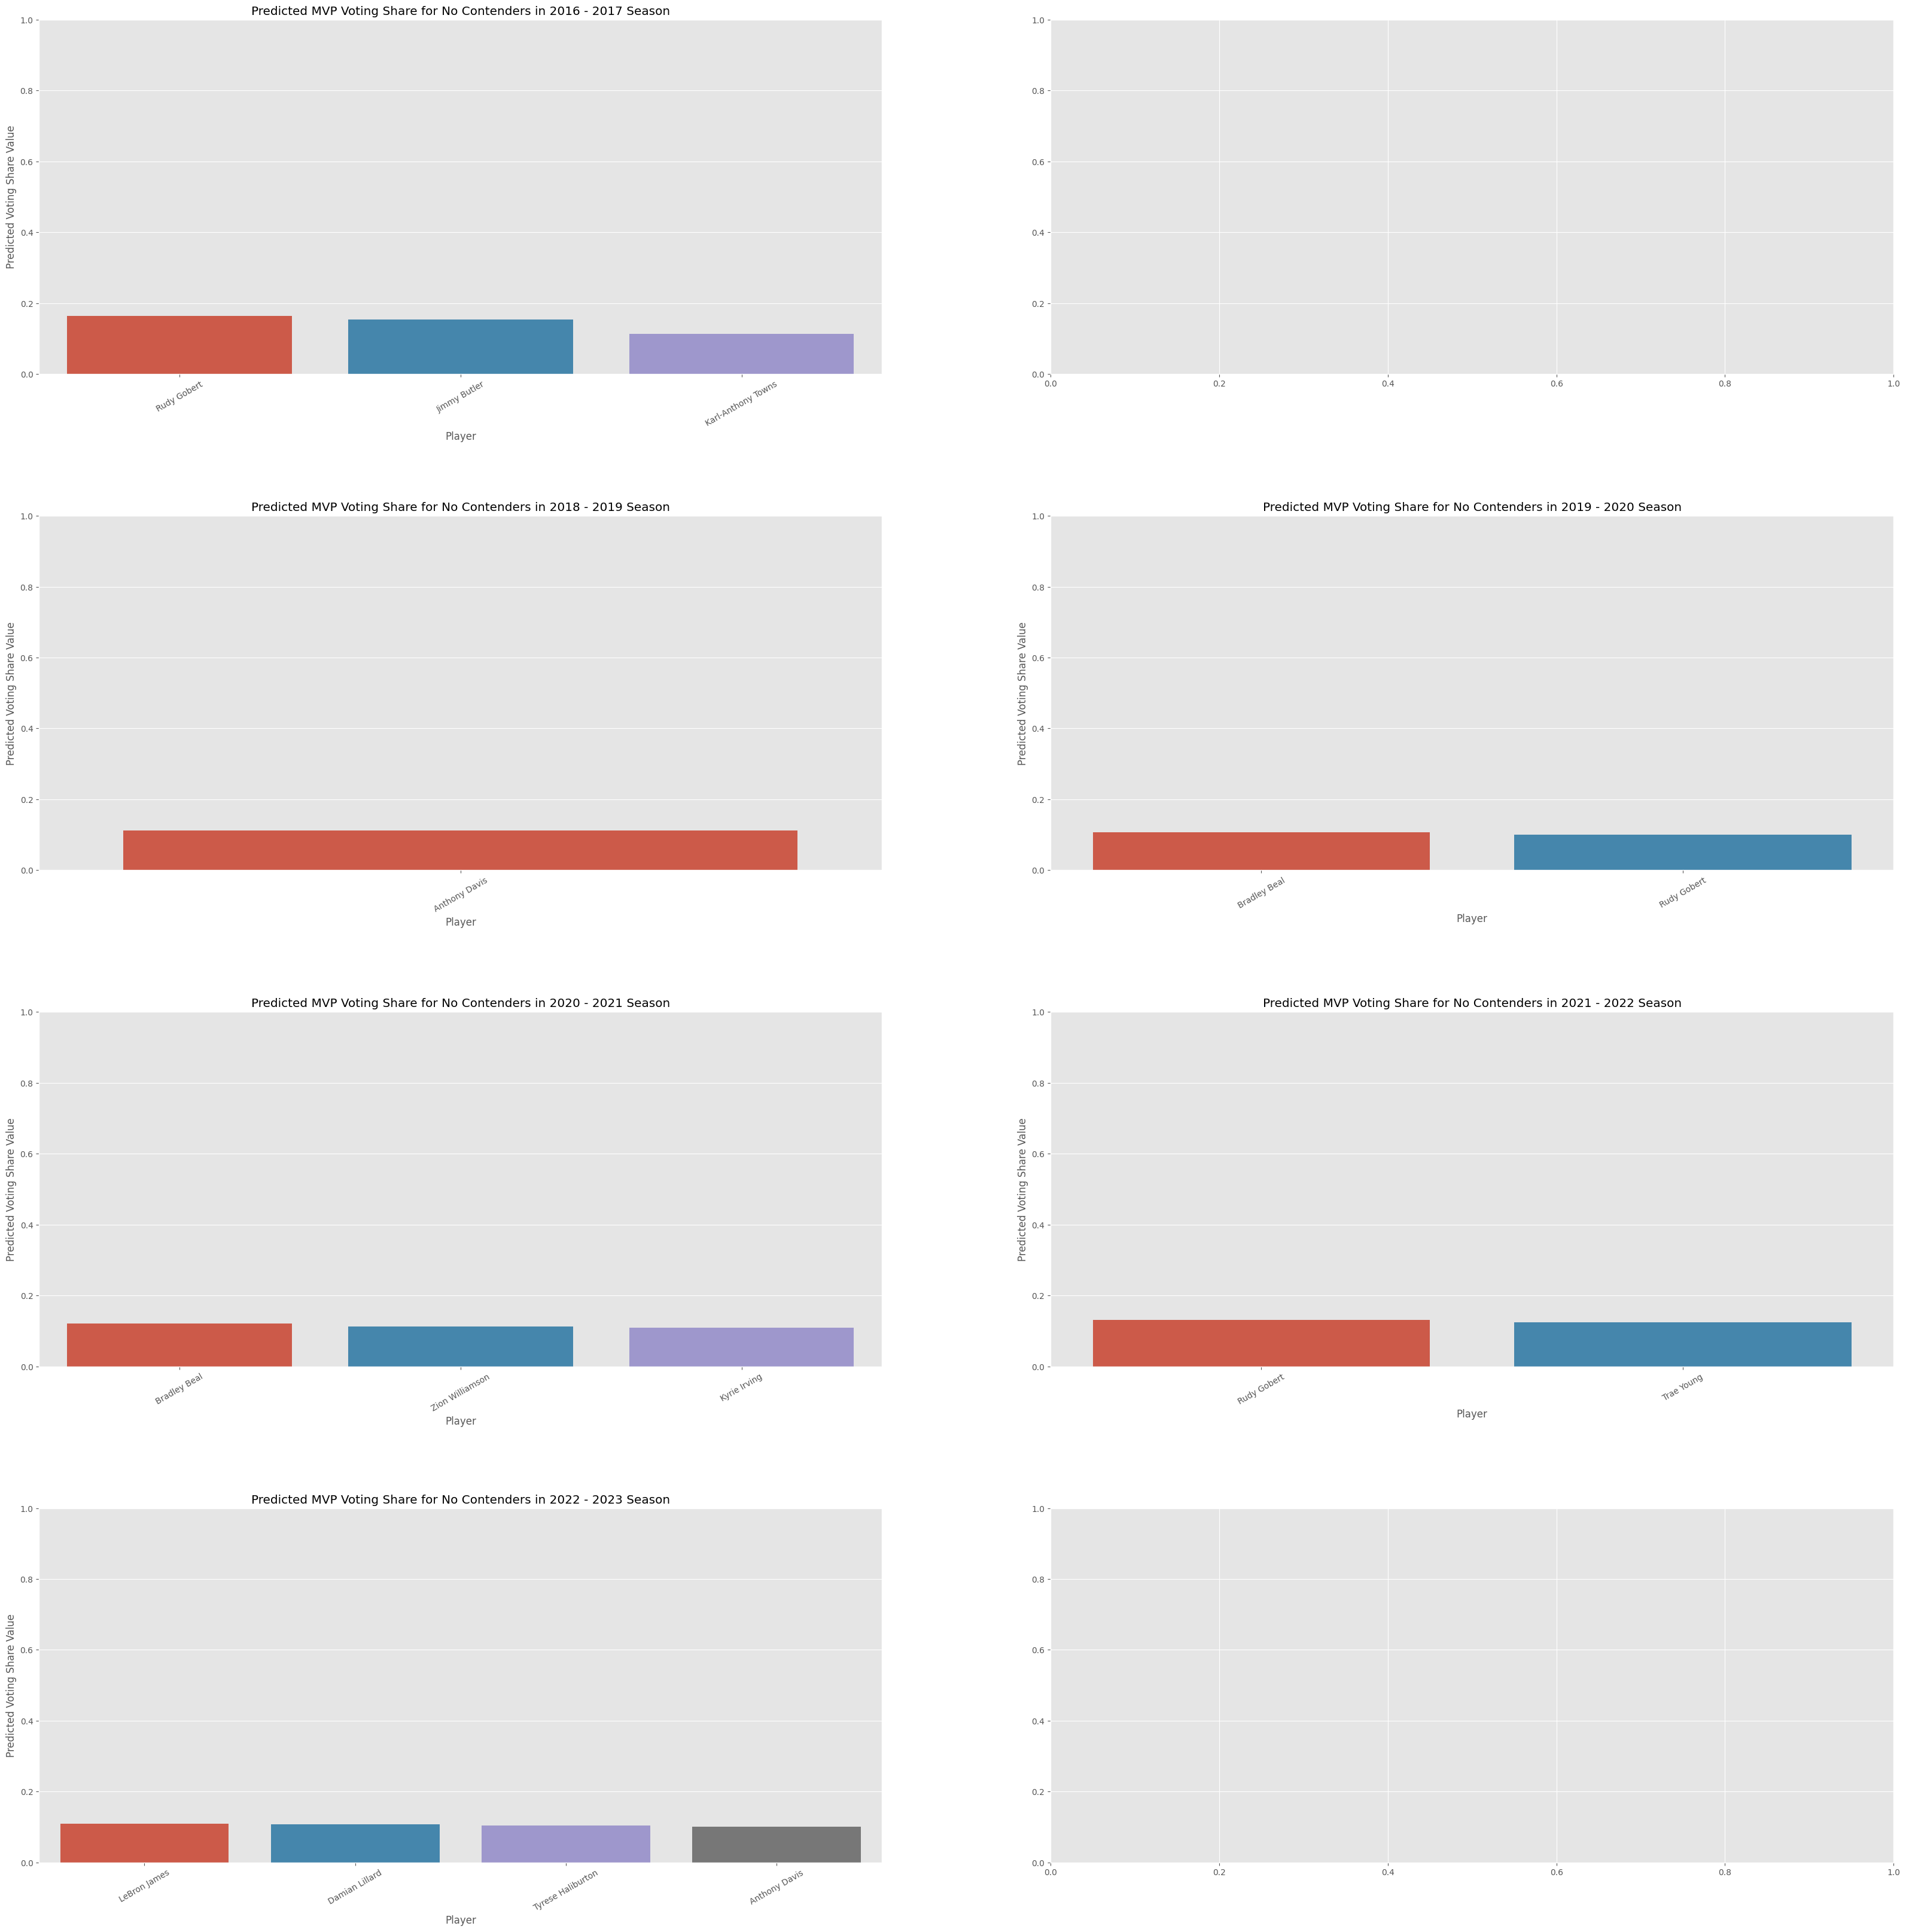

In [ ]:
mod.display_val_results_graphs(real_targets['val'], predicted_targets['val'], pipe_clean['DropPlayers'].players_list)